<a href="https://colab.research.google.com/github/markvasin/deep_learning_exercise/blob/master/lab5/Lab5_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

     |████████████████████████████████| 143kB 8.6MB/s 


In [ ]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import numpy as np   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

##Regression Data

In [ ]:
class MyDataset(Dataset):
  def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

  def __getitem__(self, index):
      if index >= len(self):
          raise IndexError("{} index out of range".format(self.__class__.__name__))

      rng_state = torch.get_rng_state()
      torch.manual_seed(index + self.random_offset)

      while True:
        img = torch.zeros(self.dim, self.dim)
        dx = torch.randint(-10,10,(1,),dtype=torch.float)
        dy = torch.randint(-10,10,(1,),dtype=torch.float)
        c = torch.randint(-20,20,(1,), dtype=torch.float)

        params = torch.cat((dy/dx, c))
        xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
        xy[:,1] = xy[:,0] * params[0] + params[1]

        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < self.dim ]
        xy = xy[ xy[:,0] < self.dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], self.dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          break

      torch.set_rng_state(rng_state)
      return img.unsqueeze(0), params

  def __len__(self):
      return self.size
    

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

# create data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

##Visualize Data

tensor([ 0.7500, -2.0000])


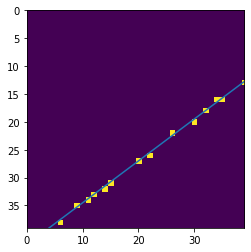

In [ ]:
img, params = train_data.__getitem__(8)
axes = plt.gca()
axes.set_xlim([0,39])
axes.set_ylim([39,0])
x_vals = np.arange(40)
y_vals = params[1] + params[0] * x_vals
plt.plot(x_vals, -y_vals+40, '-')
plt.imshow(img[0])
print(params)

## 1. Simple CNN Baseline

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(76800, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# build the model
model = SimpleCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 18.0357723236084, 'test_mse': 17.985654830932617}


###Prediction

In [ ]:
img, params = train_data.__getitem__(5)
batch = img.unsqueeze(0).to(device)
predictions = model(batch)
print('prediction: ', predictions)
print('true value: ', params)

prediction:  tensor([[  4.6345, -13.4083]], device='cuda:0', grad_fn=<AddmmBackward>)
true value:  tensor([  4., -13.])


###Comments


The mean square error of the test set is 14.23,
while the MSE of the training set is 1.09.
This model has large number of nodes in the final hidden layer, so the model overfits (as we can see from the MSE between training and test set).

##2. CNN with Global Pooling

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = F.adaptive_max_pool2d(out, output_size=1)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# build the model
model = CNN2()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 14.038326263427734, 'test_mse': 14.005232810974121}


###Comments

The mean square error on the test set is 14.28, while the MSE on the training set in the last epoch is 11.91. The performance is roughly the same as the previous model, but the model is not overfit anymore.

##3. Final CNN

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        idxx = torch.repeat_interleave(torch.arange(-20, 20, dtype=torch.float).unsqueeze(0) / 40.0, repeats=40, dim=0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x = torch.cat([x, idx], dim=1)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = F.adaptive_max_pool2d(out, output_size=1)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# build the model
model = CNN3()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

{'test_loss': 1.607198715209961, 'test_mse': 1.5992987155914307}


###Visualization of Prediction



prediction:  [[ 1.1783512 -7.9187264]]
true value:  tensor([ 1., -7.])


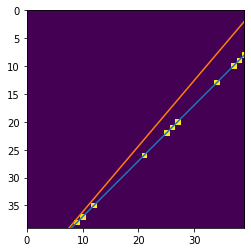

In [ ]:
img, params = test_data.__getitem__(8)
batch = img.unsqueeze(0).to(device)
predictions = model(batch).to('cpu').detach().numpy() 
print('prediction: ', predictions)
print('true value: ', params)

axes = plt.gca()
axes.set_xlim([0,39])
axes.set_ylim([39,0])

# true line
x_vals = np.arange(40)
y_vals = params[1] + params[0] * x_vals
plt.plot(x_vals, -y_vals+40, '-')

# predicted line
x_vals = np.arange(40)
y_vals = predictions[0][1] + predictions[0][0] * x_vals
plt.plot(x_vals, -y_vals+40, '-')
plt.imshow(img[0])


###Comments

The MSE of the test set is 1.22, while the MSE of the training set is 0.76. This model performs a lot better compare to the previous 2 models.

Rational for the modification:
Data augmentation? with noise?
Visualize modification!
Regualization with noise
Performance

tensor([[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        ...,
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]])


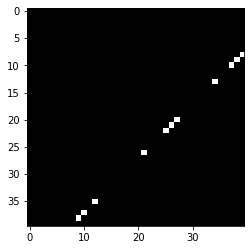

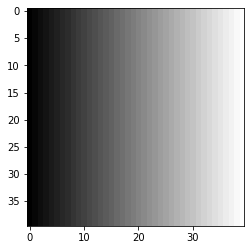

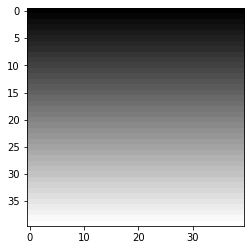

In [ ]:
img, params = test_data.__getitem__(8)
x = img.unsqueeze(0)

idxx = torch.repeat_interleave(torch.arange(-20, 20, dtype=torch.float).unsqueeze(0) / 40.0, repeats=40, dim=0)
print(idxx)
idxy = idxx.clone().t()
idx = torch.stack([idxx, idxy]).unsqueeze(0)
idx = torch.repeat_interleave(idx, repeats=1, dim=0)
x = torch.cat([x, idx], dim=1)
plt.figure()
plt.imshow(x[0][0], cmap=plt.get_cmap('gray'))
plt.figure()
plt.imshow(x[0][1], cmap=plt.get_cmap('gray'))
plt.figure()
plt.imshow(x[0][2], cmap=plt.get_cmap('gray'))


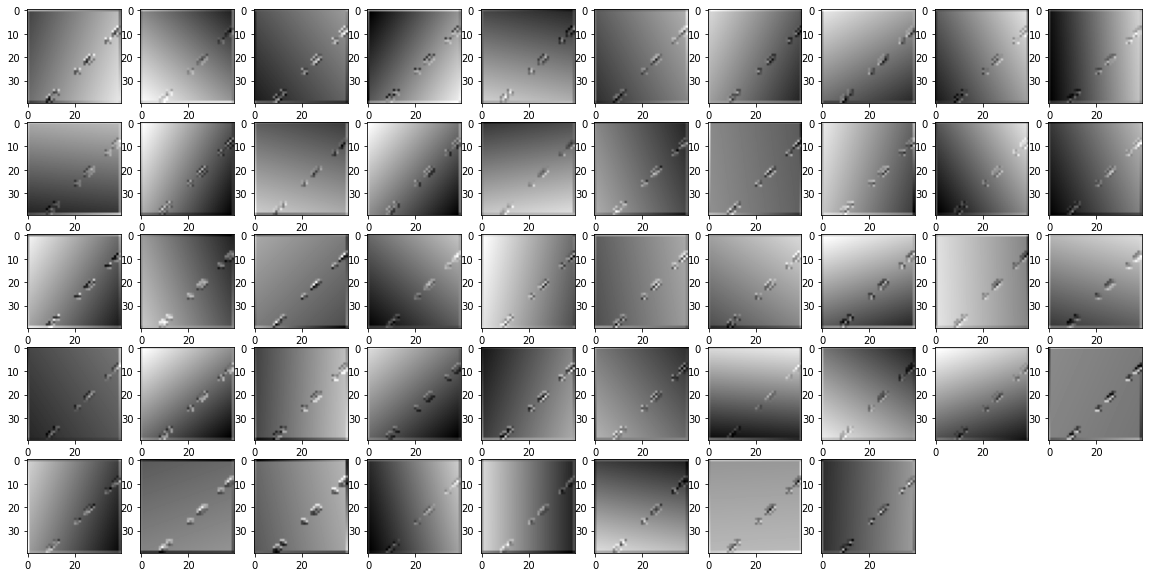

In [ ]:
model = CNN3()

from PIL import Image
import torchvision

img, params = test_data.__getitem__(8)
im = img.unsqueeze(0)

def hook_function(module, grad_in, grad_out):
    plt.figure(figsize=(20,10))
    for i in range(grad_out.shape[1]):
        conv_output = grad_out.data[0, i]
        plt.subplot(5, int(1+grad_out.shape[1]/5), i+1)
        plt.imshow(conv_output, cmap=plt.get_cmap('gray'))
        
hook = model.conv1.register_forward_hook(hook_function) # register the hook
model(im)  # forward pass
hook.remove() #Tidy up